# Iris Classification Project – Part 1

## Importer pakker og last inn data

In [255]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Load class data
x1 = np.loadtxt("class_1", delimiter=",")
x2 = np.loadtxt("class_2", delimiter=",")
x3 = np.loadtxt("class_3", delimiter=",")

# Combine data and labels
X = np.vstack([x1, x2, x3])
y = np.array([0]*50 + [1]*50 + [2]*50)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))


## Definer funksjoner


In [256]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(Xb, W):
    g = sigmoid(np.dot(Xb, W))
    return np.argmax(g, axis=1)

def train_linear_classifier(Xb, y, alpha=0.01, epochs=1000):
    np.random.seed(0)
    W = np.random.randn(Xb.shape[1], y.shape[1]) * 0.01
    for _ in range(epochs):
        z = np.dot(Xb, W)
        g = sigmoid(z)
        grad = np.dot(Xb.T, (g - y) * g * (1 - g))
        W -= alpha * grad
    return W

def train_with_mse_tracking(Xb, y, alpha=0.01, epochs=500):
    np.random.seed(0)
    W = np.random.randn(Xb.shape[1], y.shape[1]) * 0.01
    mse_values = []
    for _ in range(epochs):
        z = np.dot(Xb, W)
        g = sigmoid(z)
        mse = 0.5 * np.mean((g - y)**2)
        mse_values.append(mse)
        grad = np.dot(Xb.T, (g - y) * g * (1 - g))
        W -= alpha * grad
    return mse_values

## Evaluer Case A


In [257]:
# Train on samples 0–29, test on 30–49
X_train, X_test, y_train, y_test = [], [], [], []

for i in range(3):
    X_train.append(X[y == i][:30])
    y_train.append(y_encoded[y == i][:30])
    X_test.append(X[y == i][30:])
    y_test.append(y_encoded[y == i][30:])

X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
X_test = np.vstack(X_test)
y_test = np.vstack(y_test)

# Add bias term
X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# Train model
W = train_linear_classifier(X_train_bias, y_train)

# Predict and evaluate
y_train_pred = predict(X_train_bias, W)
y_test_pred = predict(X_test_bias, W)

train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

conf_train = confusion_matrix(train_true, y_train_pred)
conf_test = confusion_matrix(test_true, y_test_pred)

err_train = 1 - np.trace(conf_train) / np.sum(conf_train)
err_test = 1 - np.trace(conf_test) / np.sum(conf_test)


## Vis resultater med plott

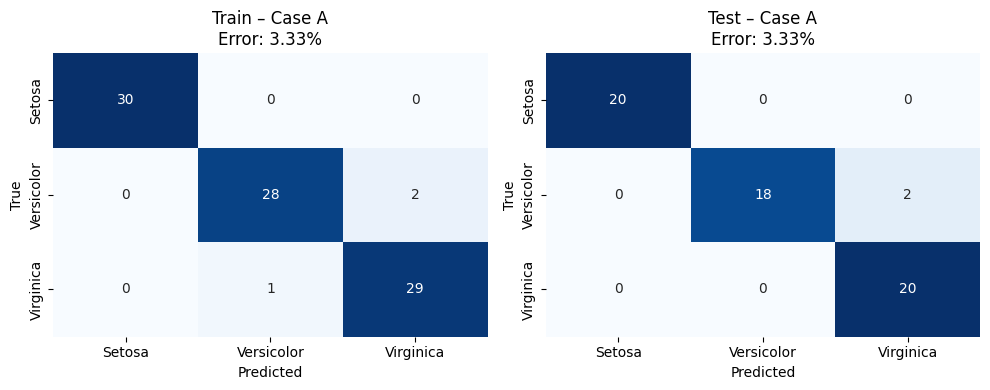

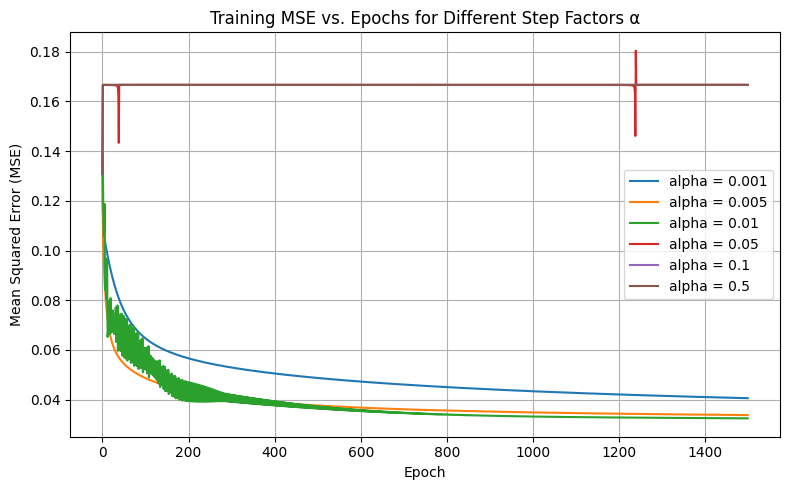

In [258]:
def plot_conf_matrix(ax, conf, title):
    sns.heatmap(conf, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Setosa", "Versicolor", "Virginica"],
                yticklabels=["Setosa", "Versicolor", "Virginica"],
                cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_conf_matrix(axes[0], conf_train, f"Train – Case A\nError: {err_train:.2%}")
plot_conf_matrix(axes[1], conf_test, f"Test – Case A\nError: {err_test:.2%}")

plt.tight_layout()
plt.show()

# MSE vs epochs for different alpha
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
mse_results = {}

for alpha in alphas:
    mse_values = train_with_mse_tracking(X_train_bias, y_train, alpha=alpha, epochs=1500)
    mse_results[alpha] = mse_values
    
plt.figure(figsize=(8, 5))
for alpha, mse_vals in mse_results.items():
    plt.plot(mse_vals, label=f"alpha = {alpha}")
plt.title("Training MSE vs. Epochs for Different Step Factors α")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Case B (reverse split)

Now we swap the splits to test how robust the model is to different data segments.


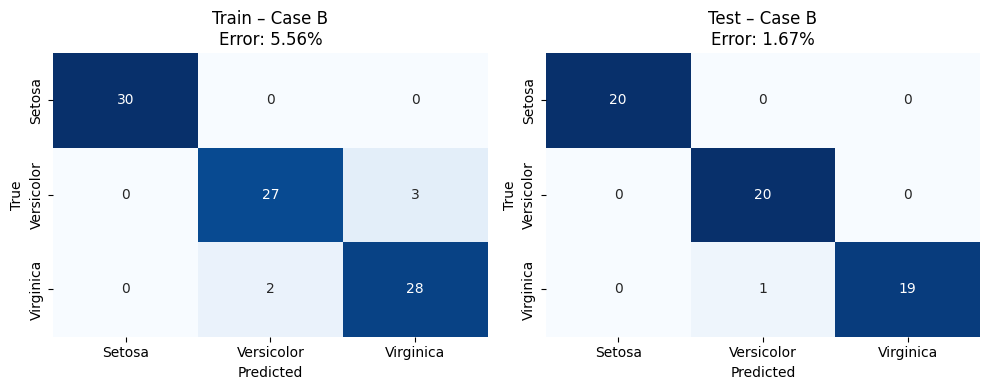

In [259]:
# Train on samples 20–49, test on 0–19
X_train, X_test, y_train, y_test = [], [], [], []

for i in range(3):
    X_train.append(X[y == i][20:])
    y_train.append(y_encoded[y == i][20:])
    X_test.append(X[y == i][:20])
    y_test.append(y_encoded[y == i][:20])

X_train = np.vstack(X_train)
y_train = np.vstack(y_train)
X_test = np.vstack(X_test)
y_test = np.vstack(y_test)

X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

W = train_linear_classifier(X_train_bias, y_train)

y_train_pred = predict(X_train_bias, W)
y_test_pred = predict(X_test_bias, W)

train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

conf_train = confusion_matrix(train_true, y_train_pred)
conf_test = confusion_matrix(test_true, y_test_pred)

err_train = 1 - np.trace(conf_train) / np.sum(conf_train)
err_test = 1 - np.trace(conf_test) / np.sum(conf_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_conf_matrix(axes[0], conf_train, f"Train – Case B\nError: {err_train:.2%}")
plot_conf_matrix(axes[1], conf_test, f"Test – Case B\nError: {err_test:.2%}")

plt.tight_layout()
plt.show()


# Part 2 – Feature Analysis and Linear Separability

## Histogrammer for alle features


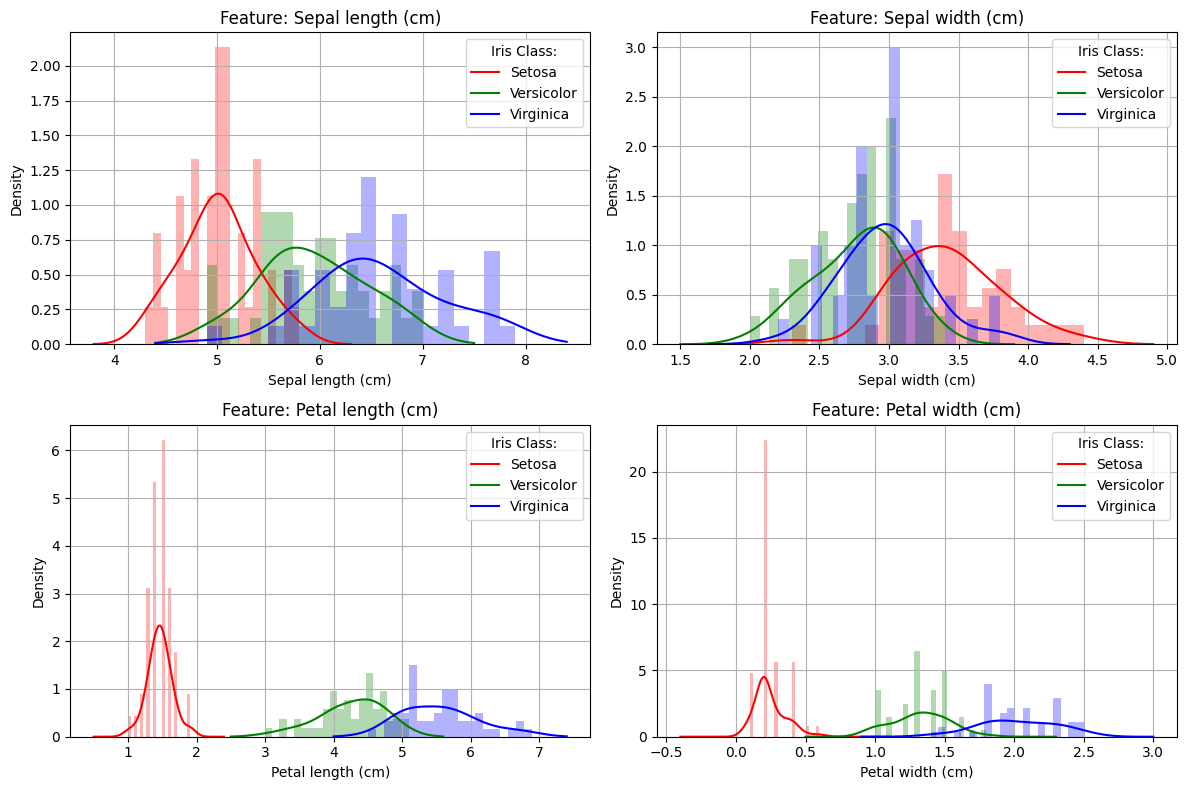

class_name    Setosa  Versicolor  Virginica
Sepal length   5.006       5.936      6.588
Sepal width    3.418       2.770      2.974
Petal length   1.464       4.260      5.552
Petal width    0.244       1.326      2.026


In [260]:
feature_names = ["Sepal length", "Sepal width", "Petal length", "Petal width"]
class_names = ["Setosa", "Versicolor", "Virginica"]
colors = ["r", "g", "b"]

df = pd.DataFrame(X, columns=feature_names)
df["class"] = y
df["class_name"] = df["class"].map({0: "Setosa", 1: "Versicolor", 2: "Virginica"})

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, feature in zip(axes.flat, feature_names):
    for cls, color in zip([0, 1, 2], colors):
        data = df[df["class"] == cls][feature]
        kde = gaussian_kde(data, bw_method=0.5)
        x_range = np.linspace(data.min() - 0.5, data.max() + 0.5, 200)
        ax.plot(x_range, kde(x_range), label=class_names[cls], color=color)
        ax.hist(data, bins=20, density=True, histtype="stepfilled", alpha=0.3, color=color)

    ax.set_title(f"Feature: {feature} (cm)")
    ax.set_xlabel(f"{feature} (cm)")
    ax.set_ylabel("Density")
    ax.grid(True)

axes[0, 0].legend(title="Iris Class:")
axes[0, 1].legend(title="Iris Class:")
axes[1, 0].legend(title="Iris Class:")
axes[1, 1].legend(title="Iris Class:")

plt.tight_layout()
plt.show()

means = df.groupby("class_name")[feature_names].mean().T
print(means)


## Definer hvilke features du vil bruke

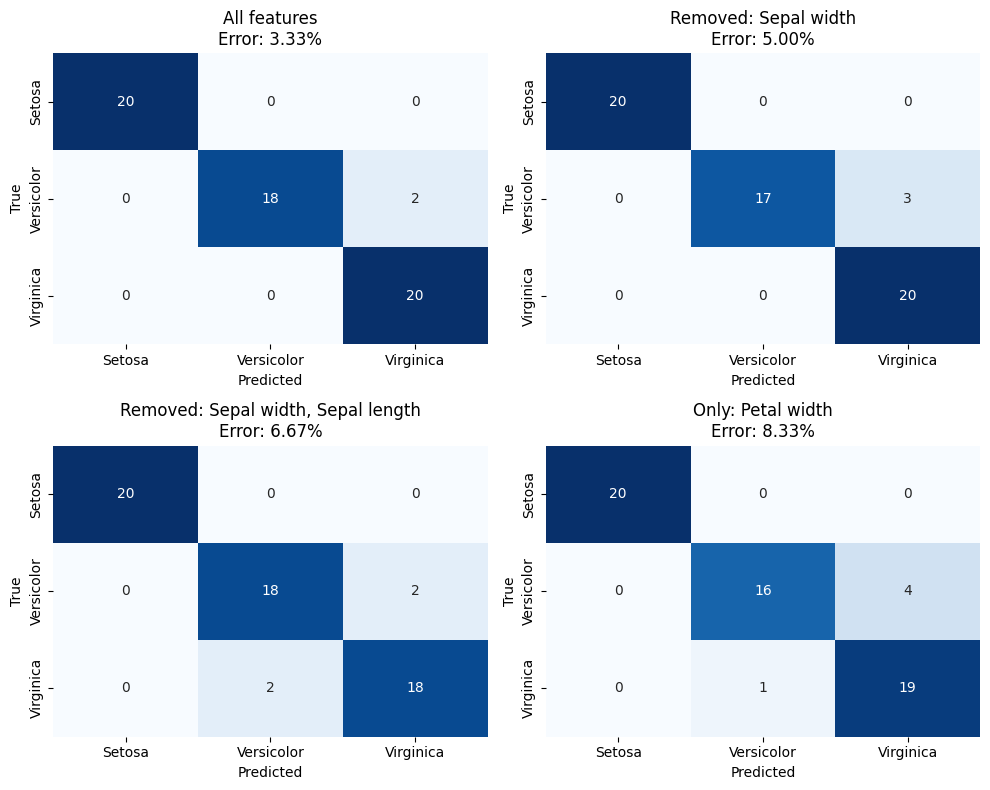

In [261]:
# Basert på histogram: sepal width (index 1) gir mest overlapp
feature_sets = {
    "4 features": [0, 1, 2, 3],
    "3 features": [0, 2, 3],
    "2 features": [2, 3],     # Petal length + width
    "1 feature": [3]          # Petal width only
}


results = []

for name, idx in feature_sets.items():
    X_sel = X[:, idx]

    X_train, X_test, y_train, y_test = [], [], [], []

    for i in range(3):
        X_train.append(X_sel[y == i][:30])
        y_train.append(y_encoded[y == i][:30])
        X_test.append(X_sel[y == i][30:])
        y_test.append(y_encoded[y == i][30:])

    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    X_test = np.vstack(X_test)
    y_test = np.vstack(y_test)

    X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

    W = train_linear_classifier(X_train_bias, y_train)

    y_pred = predict(X_test_bias, W)
    y_true = np.argmax(y_test, axis=1)
    conf = confusion_matrix(y_true, y_pred)
    error = 1 - np.trace(conf) / np.sum(conf)

    results.append((name, conf, error))
    
# Plot all confusion matrices in a 2x2 layout
titles = {
    "4 features": "All features",
    "3 features": "Removed: Sepal width",
    "2 features": "Removed: Sepal width, Sepal length",
    "1 feature": "Only: Petal width"
}

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, (name, conf, err) in zip(axes.flat, results):
    sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Setosa", "Versicolor", "Virginica"],
                yticklabels=["Setosa", "Versicolor", "Virginica"],
                ax=ax)
    ax.set_title(f"{titles[name]}\nError: {err:.2%}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Iris data (petal length vs width)')

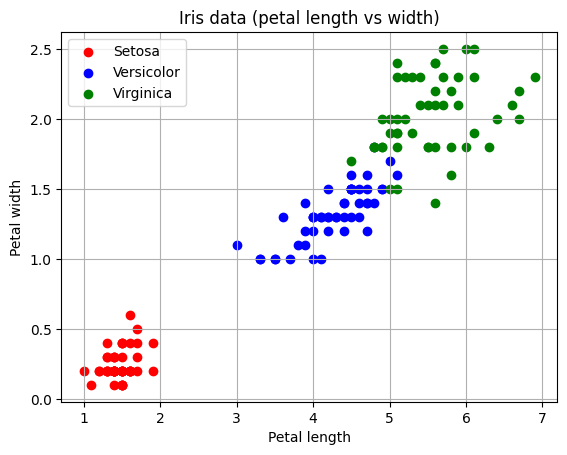

In [263]:
plt.scatter(X[y == 0, 2], X[y == 0, 3], color='red', label='Setosa')
plt.scatter(X[y == 1, 2], X[y == 1, 3], color='blue', label='Versicolor')
plt.scatter(X[y == 2, 2], X[y == 2, 3], color='green', label='Virginica')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend()
plt.grid()
plt.title('Iris data (petal length vs width)')